## Battery State of Charge Estimation using Kalman Filter

In [27]:
import numpy as np
import pandas as pd

def kalman_filter_with_control(max_iter, x_hat, P, A, B, C, D, sigma_w, sigma_v, data_path, start_point=30000):
    """
    Apply Kalman Filter with control inputs to estimate the state of a linear dynamic system.

    Parameters:
    - max_iter: Number of iterations for the Kalman filter.
    - x_hat: Initial state estimate (numpy array).
    - P: Initial error covariance estimate (numpy array).
    - A, B, C, D: System matrices (numpy arrays).
    - sigma_w: Process noise covariance matrix.
    - sigma_v: Measurement noise covariance matrix.
    - data_path: Path to the CSV file containing the input data.
    - start_point: Starting index for data extraction.

    Returns:
    - x_store: True state over iterations.
    - x_hat_store: Estimated state over iterations.
    - P_store: Error covariance over iterations.
    """
    # Read and preprocess data
    file = pd.read_csv(data_path)
    current = pd.to_numeric(file[' Current (A)']) / 1000
    soc = pd.to_numeric(file['SOC'].str.rstrip('%'))

    u = np.array([[current[start_point]]])
    x_true = np.array([[soc[start_point]]])

    # Initialize storage arrays
    x_store = np.zeros((max_iter + 1, len(x_true)))
    x_hat_store = np.zeros((max_iter, len(x_hat)))
    P_store = np.zeros((max_iter, len(x_hat)**2))

    # Store the initial state
    x_store[0, :] = x_true

    for k in range(1, max_iter):
        # Prediction Step
        x_hat = A @ x_hat + B @ u
        P = A @ P @ A.T + sigma_w

        # Update the control input and true state from data
        u = np.array([[current[k + start_point]]])
        x_true = np.array([[soc[k + start_point]]])

        # Simulate process and measurement noise
        w = np.linalg.cholesky(sigma_w) @ np.random.randn(len(x_true))
        v = np.linalg.cholesky(sigma_v) @ np.random.randn(len(C @ x_true))

        x_true = A @ x_true + B * u + w
        y_true = C @ x_true + D * u + v

        # Estimate system output
        y_hat = C @ x_hat + D @ u

        # Measurement Update Step
        S = C @ P @ C.T + sigma_v
        K = P @ C.T @ np.linalg.inv(S)
        x_hat = x_hat + K @ (y_true - y_hat)
        P = (np.eye(P.shape[0]) - K @ C) @ P

        # Store results
        x_store[k, :] = x_true
        x_hat_store[k - 1, :] = x_hat
        P_store[k - 1, :] = P.flatten()

    return x_store, x_hat_store, P_store

# Example usage
Q = 2900  # mAh
slope = 0.8  # OCV-SOC Curve
R0 = -0.06345  # Ohm
# Define initial parameters
x_hat = np.array([[0.5]])
P = np.array([[0.5]])
A = np.array([[1.]])
B = np.array([[-1/Q]])
C = np.array([[slope]])
D = np.array([[R0]])
sigma_w = np.array([[1e-4]])
sigma_v = np.array([[0.1]])
max_iter = 100
data_path = 'discharge/cap_discharge_test.csv'

# Run Kalman Filter
x_store, x_hat_store, P_store = kalman_filter_with_control(max_iter, x_hat, P, A, B, C, D, sigma_w, sigma_v, data_path)


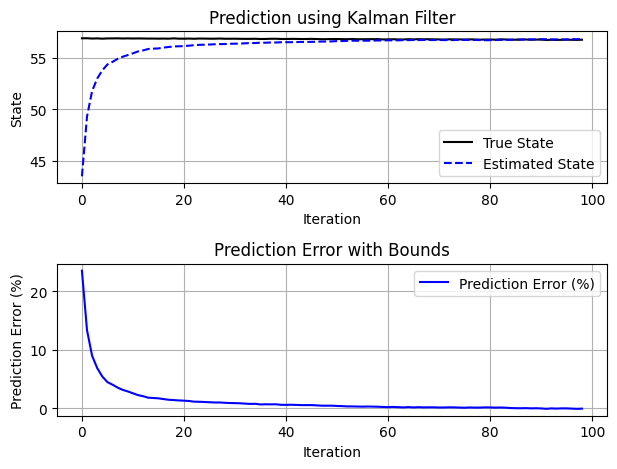

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def plot_kalman_results(max_iter, x_store, x_hat_store, P_store):
    """
    Plot the true states, estimated states, and prediction errors from the Kalman filter.

    Parameters:
    - max_iter: Total number of iterations used in the Kalman filter.
    - x_store: Array of true states over iterations.
    - x_hat_store: Array of estimated states over iterations.
    - P_store: Array of error covariance estimates over iterations.
    """
    # Ensure consistent data lengths for plotting
    iteration_range = np.arange(max_iter - 1)

    # Set up the first subplot for true vs. estimated state
    plt.subplot(2, 1, 1)
    plt.plot(iteration_range, x_store[:max_iter - 1], 'k-', label='True State')
    plt.plot(iteration_range, x_hat_store[:max_iter - 1], 'b--', label='Estimated State')
    # Optional bounds can be enabled if desired:
    # upper_bound = x_hat_store[:max_iter - 1] + 3 * np.sqrt(P_store[:max_iter - 1])
    # lower_bound = x_hat_store[:max_iter - 1] - 3 * np.sqrt(P_store[:max_iter - 1])
    # plt.plot(iteration_range, upper_bound, 'm-.', label='Upper Bound')
    # plt.plot(iteration_range, lower_bound, 'm-.', label='Lower Bound')
    plt.grid(True)
    plt.legend()
    plt.title('Prediction using Kalman Filter')
    plt.xlabel('Iteration')
    plt.ylabel('State')

    # Set up the second subplot for prediction errors
    plt.subplot(2, 1, 2)
    est_error = (x_store[:max_iter - 1] - x_hat_store[:max_iter - 1]) / x_store[:max_iter - 1] * 100
    plt.plot(iteration_range, est_error, 'b-', label='Prediction Error (%)')
    # Optional error bounds can be enabled if desired:
    # plt.plot(iteration_range, 3 * np.sqrt(P_store), 'm--', label='Upper Bound')
    # plt.plot(iteration_range, -3 * np.sqrt(P_store), 'm--', label='Lower Bound')
    plt.grid(True)
    plt.legend()
    plt.title('Prediction Error with Bounds')
    plt.xlabel('Iteration')
    plt.ylabel('Prediction Error (%)')

    # Adjust subplot layout to avoid overlapping
    plt.tight_layout()

    # Display all plots
    plt.show()

# Example usage:
# Ensure that `max_iter`, `x_store`, `x_hat_store`, and `P_store` are already defined.
plot_kalman_results(max_iter, x_store, x_hat_store, P_store)
